In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Kaggle setup
import os
import zipfile

# Mount Google Drive if needed (uncomment if using Google Drive)
# from google.colab import drive
# drive.mount('/content/drive')

# Unzip dataset if needed
# with zipfile.ZipFile('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('/kaggle/working/')

# Set paths
DATA_DIR = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'  # Update this path
os.makedirs('/kaggle/working/models', exist_ok=True)

In [3]:
# 1. Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
from tqdm import tqdm  # For progress bars

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# 2. Configuration
class Config:
    def __init__(self):
        self.batch_size = 64  # Increased batch size for GPU
        self.learning_rate = 0.001
        self.num_epochs = 10
        self.val_split = 0.15
        self.test_split = 0.15
        self.num_classes = 4  # 4 types of dementia
        self.num_workers = 2  # For data loading

Using device: cuda
GPU Name: Tesla T4


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        
        # Feature extraction
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        # Add adaptive pooling to handle any input size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Classifier (input size is now fixed due to adaptive pooling)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),  # Fixed size after adaptive pooling
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)  # This ensures consistent output size
        x = self.classifier(x)
        return x

# Initialize model with DataParallel for multi-GPU support
def get_model(num_classes=4):
    model = SimpleCNN(num_classes=num_classes)
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs with DataParallel!")
            model = nn.DataParallel(model)
        model = model.to('cuda')
    return model

In [5]:
# Function to prepare data loaders for train, val, and test sets
def get_data_loaders(config):
    # Define image transformations for training dataset (includes augmentation)
    train_transform = transforms.Compose([
        transforms.Grayscale(),                    # Convert image to grayscale (1 channel)
        transforms.Resize((256, 256)),             # Resize all images to 256x256
        transforms.RandomHorizontalFlip(),         # Random horizontal flip (augmentation)
        transforms.RandomRotation(10),             # Random rotation within ±10 degrees (augmentation)
        transforms.ToTensor(),                     # Convert PIL image to PyTorch tensor
        transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize grayscale pixel values to [-1, 1]
    ])

    # Validation/test transform (no augmentation)
    val_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Load dataset from specified directory using ImageFolder
    full_dataset = datasets.ImageFolder(
        root='/kaggle/input/imagesoasis/Data',  # Replace with actual data path
        transform=train_transform               # Initial transform
    )

    # Compute sizes for validation and test sets
    val_size = int(len(full_dataset) * config.val_split)
    test_size = int(len(full_dataset) * config.test_split)
    train_size = len(full_dataset) - val_size - test_size

    # Randomly split the dataset into train, val, and test subsets
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    # Override transform for val and test datasets
    val_dataset.dataset.transform = val_transform
    test_dataset.dataset.transform = val_transform

    # Create data loaders with GPU optimization options
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader


code to check 
✅ Confirm dataset split sizes (train/val/test)

✅ Print per-class distribution in each split

✅ Check class imbalance with percentages

✅ Visualize the class distribution using bar charts


📊 Class Distribution - Training Set
Mild Dementia: 3440 samples (5.69%)
Moderate Dementia: 313 samples (0.52%)
Non Demented: 47103 samples (77.85%)
Very mild Dementia: 9651 samples (15.95%)

📊 Class Distribution - Validation Set
Mild Dementia: 820 samples (6.32%)
Moderate Dementia: 93 samples (0.72%)
Non Demented: 10060 samples (77.59%)
Very mild Dementia: 1992 samples (15.36%)

📊 Class Distribution - Test Set
Mild Dementia: 742 samples (5.72%)
Moderate Dementia: 82 samples (0.63%)
Non Demented: 10059 samples (77.59%)
Very mild Dementia: 2082 samples (16.06%)


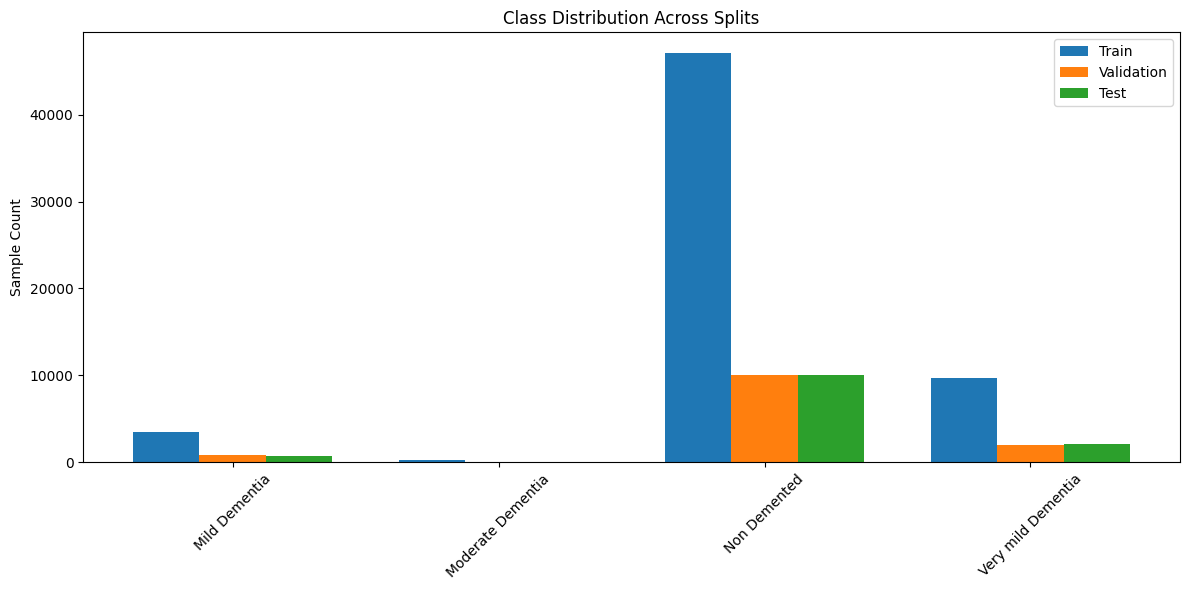

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def print_class_distribution(data_loader, split_name):
    print(f"\n{'='*60}")
    print(f"📊 Class Distribution - {split_name}")
    print("="*60)

    class_counts = {}
    total = 0

    for _, labels in data_loader:
        for label in labels:
            label = label.item()
            class_counts[label] = class_counts.get(label, 0) + 1
            total += 1

    # Get class names if available
    if hasattr(data_loader.dataset, 'dataset') and hasattr(data_loader.dataset.dataset, 'classes'):
        class_names = data_loader.dataset.dataset.classes
    elif hasattr(data_loader.dataset, 'classes'):
        class_names = data_loader.dataset.classes
    else:
        class_names = [f"Class {i}" for i in sorted(class_counts.keys())]

    # Print distribution
    for idx in sorted(class_counts.keys()):
        count = class_counts[idx]
        percent = 100 * count / total
        print(f"{class_names[idx]}: {count} samples ({percent:.2f}%)")
    
    return class_counts, class_names

def plot_distribution(train_counts, val_counts, test_counts, class_names):
    indices = np.arange(len(class_names))
    width = 0.25

    train_vals = [train_counts.get(i, 0) for i in indices]
    val_vals = [val_counts.get(i, 0) for i in indices]
    test_vals = [test_counts.get(i, 0) for i in indices]

    plt.figure(figsize=(12, 6))
    plt.bar(indices - width, train_vals, width, label='Train')
    plt.bar(indices, val_vals, width, label='Validation')
    plt.bar(indices + width, test_vals, width, label='Test')

    plt.xticks(indices, class_names, rotation=45)
    plt.ylabel("Sample Count")
    plt.title("Class Distribution Across Splits")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage
config = Config()
train_loader, val_loader, test_loader = get_data_loaders(config)

train_counts, class_names = print_class_distribution(train_loader, "Training Set")
val_counts, _ = print_class_distribution(val_loader, "Validation Set")
test_counts, _ = print_class_distribution(test_loader, "Test Set")

plot_distribution(train_counts, val_counts, test_counts, class_names)


In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_training_history(history):
    """Plot training and validation metrics."""
    plt.figure(figsize=(15, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [8]:
def train_model(model, train_loader, val_loader, config):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=3, factor=0.5, verbose=True
    )
    
    # Initialize history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'lr': [], 'epoch_times': []
    }
    
    # Training loop
    for epoch in range(config.num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Wrap train_loader with tqdm for progress bar
        train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.num_epochs} [Train]')
        for images, labels in train_loop:
            # Move data to GPU
            images, labels = images.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # Update progress bar
            train_loop.set_postfix(loss=loss.item(), acc=100.*correct_train/total_train)
        
        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation phase
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Record history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        history['epoch_times'].append(time.time() - start_time)
        
        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{config.num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%')
        print(f'  Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f} | Time: {history["epoch_times"][-1]:.2f}s')
        
        # Plot training history
        plot_training_history(history)
    
    return model, history

def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        val_loop = tqdm(val_loader, desc='Validation')
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            val_loop.set_postfix(loss=loss.item(), acc=100.*correct/total)
    
    return val_loss / len(val_loader), 100 * correct / total

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using 2 GPUs with DataParallel!
Model Architecture:
DataParallel(
  (module): SimpleCNN(
    (features): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (adaptive_pool): AdaptiveAvgPool2d(output_size=(7, 7))
    (classifier): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=6272, out_features=512, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=512, out_features=4, bias=True)
    )
  )
)

To

Validation: 100%|██████████| 203/203 [00:20<00:00, 10.15it/s, acc=87.7, loss=0.338]



Epoch 1/10:
  Train Loss: 0.4955 | Train Acc: 80.82%
  Val Loss: 0.3150 | Val Acc: 87.73%
  LR: 0.001000 | Time: 117.58s


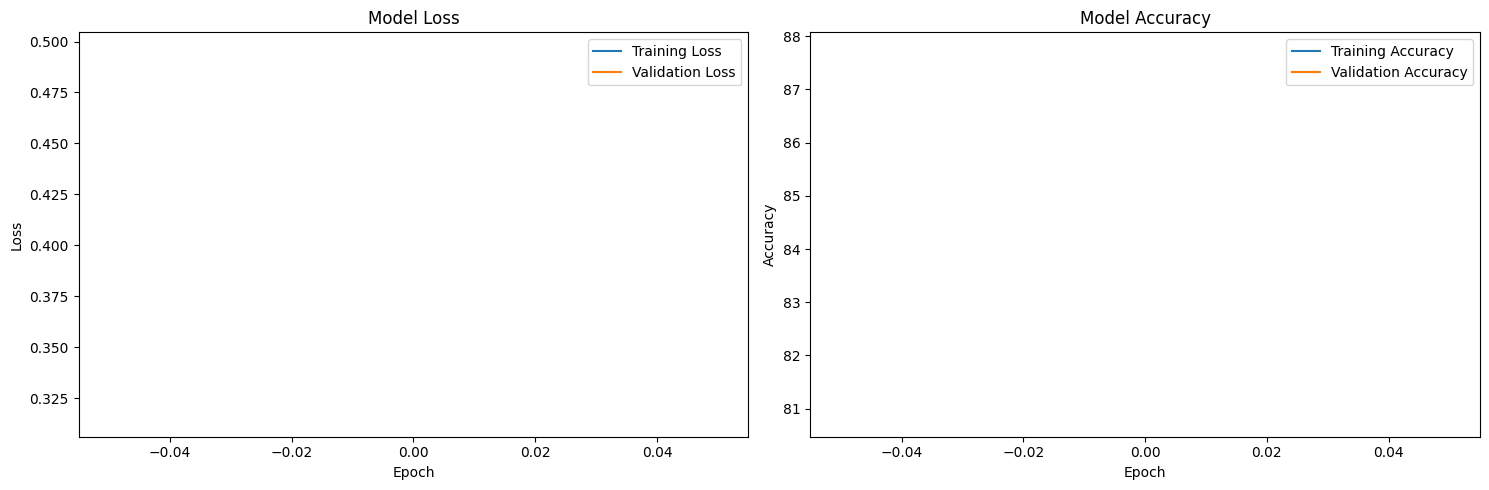

Validation: 100%|██████████| 203/203 [00:19<00:00, 10.23it/s, acc=96.4, loss=0.123] 



Epoch 2/10:
  Train Loss: 0.2457 | Train Acc: 90.19%
  Val Loss: 0.1222 | Val Acc: 96.43%
  LR: 0.001000 | Time: 117.29s


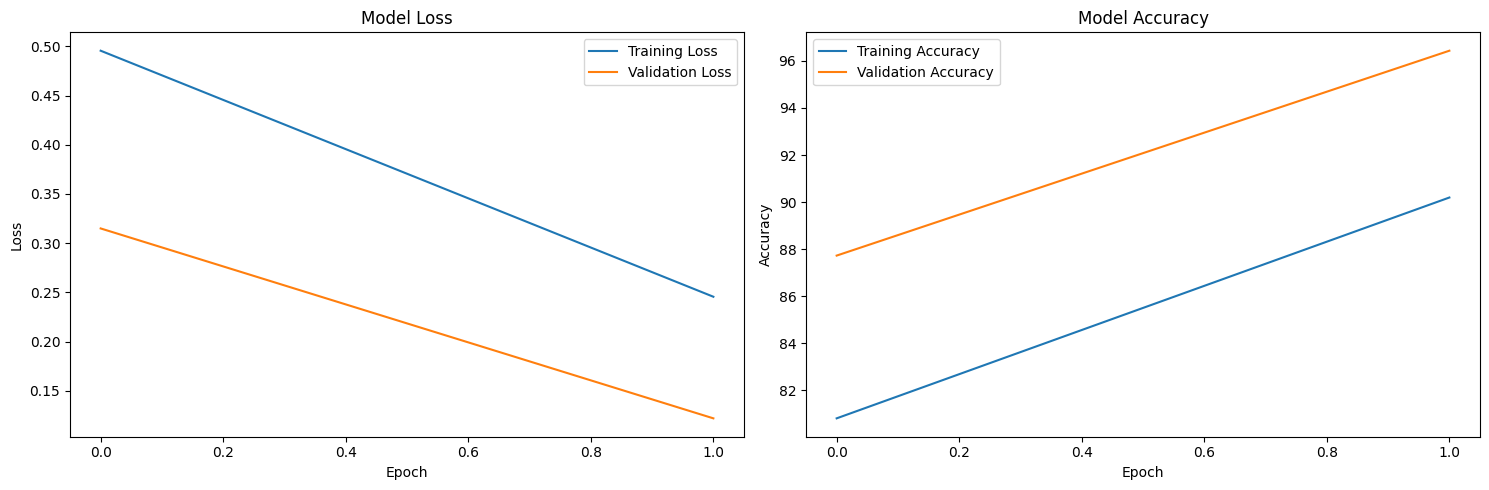

Validation: 100%|██████████| 203/203 [00:19<00:00, 10.16it/s, acc=98.8, loss=0.0423] 



Epoch 3/10:
  Train Loss: 0.1149 | Train Acc: 95.81%
  Val Loss: 0.0421 | Val Acc: 98.77%
  LR: 0.001000 | Time: 117.79s


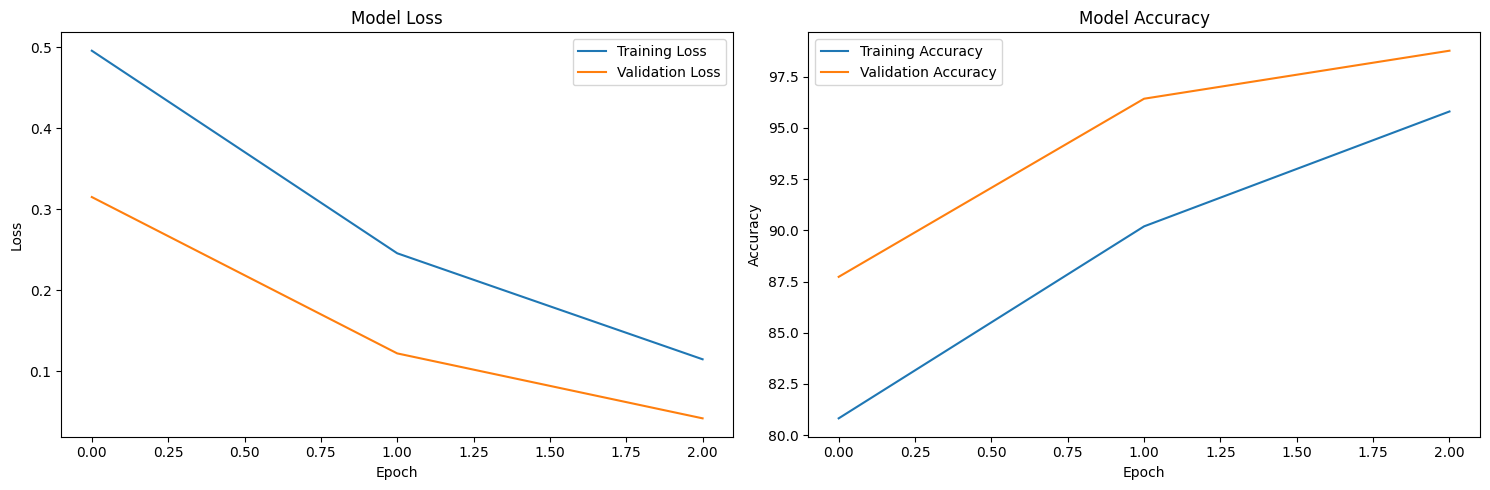

Validation: 100%|██████████| 203/203 [00:20<00:00,  9.94it/s, acc=99.4, loss=0.0225] 



Epoch 4/10:
  Train Loss: 0.0678 | Train Acc: 97.62%
  Val Loss: 0.0250 | Val Acc: 99.36%
  LR: 0.001000 | Time: 119.52s


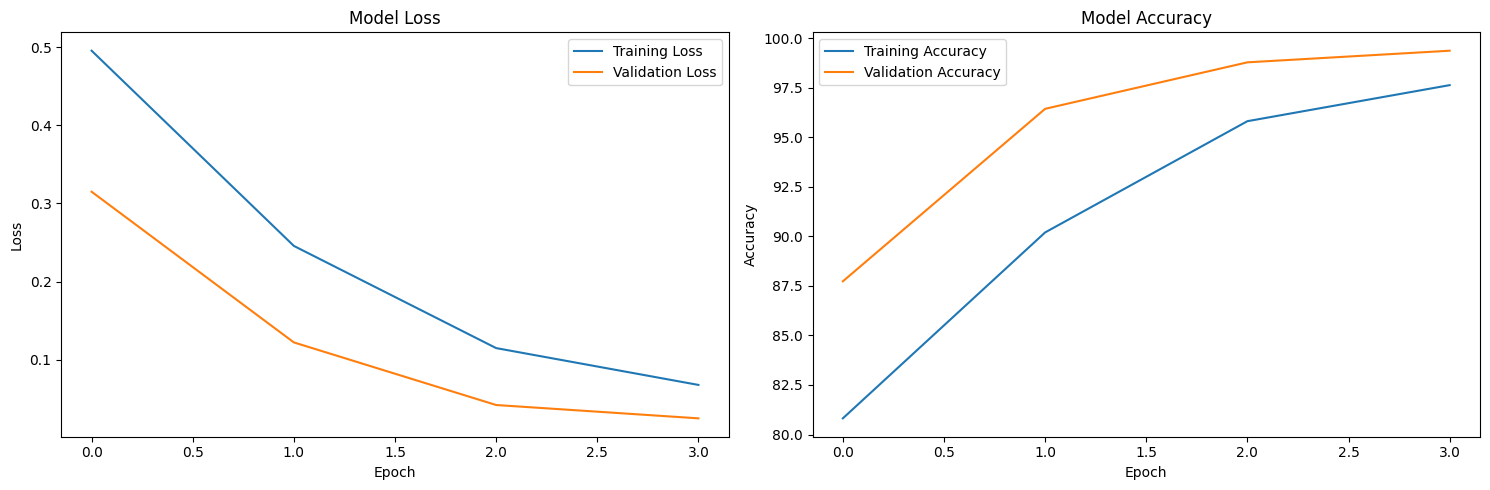

Validation: 100%|██████████| 203/203 [00:20<00:00, 10.07it/s, acc=99.4, loss=0.023]  



Epoch 5/10:
  Train Loss: 0.0439 | Train Acc: 98.42%
  Val Loss: 0.0190 | Val Acc: 99.42%
  LR: 0.001000 | Time: 117.64s


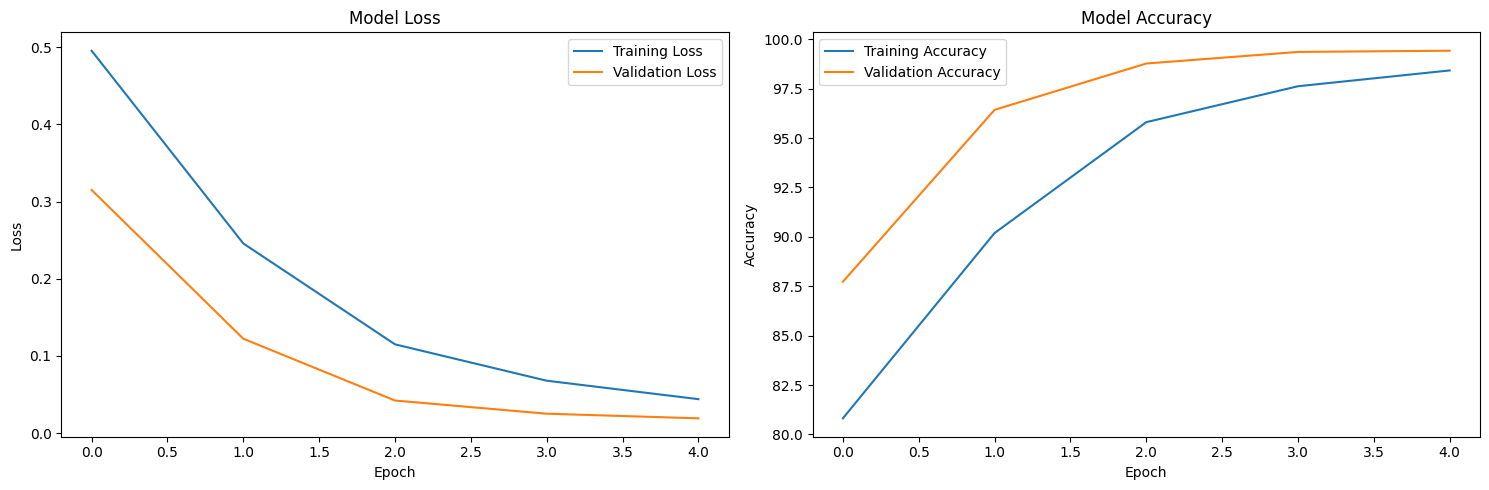

Validation: 100%|██████████| 203/203 [00:19<00:00, 10.30it/s, acc=99.8, loss=0.00172] 



Epoch 6/10:
  Train Loss: 0.0342 | Train Acc: 98.80%
  Val Loss: 0.0090 | Val Acc: 99.75%
  LR: 0.001000 | Time: 118.65s


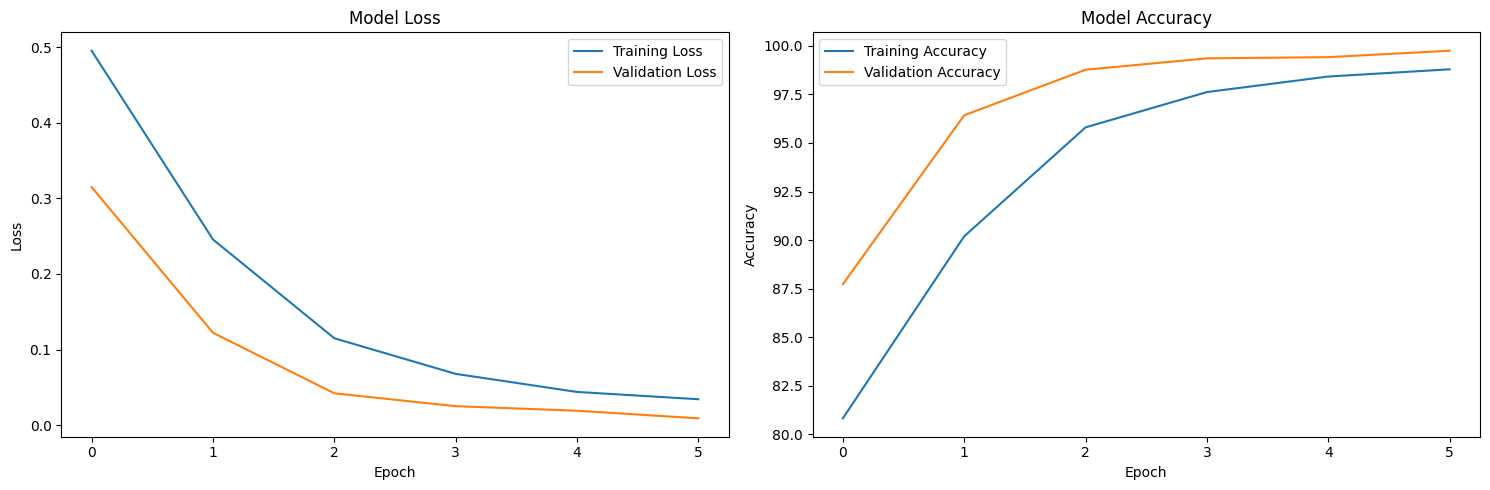

Validation: 100%|██████████| 203/203 [00:19<00:00, 10.30it/s, acc=99.8, loss=0.00291] 



Epoch 7/10:
  Train Loss: 0.0288 | Train Acc: 98.98%
  Val Loss: 0.0053 | Val Acc: 99.85%
  LR: 0.001000 | Time: 118.59s


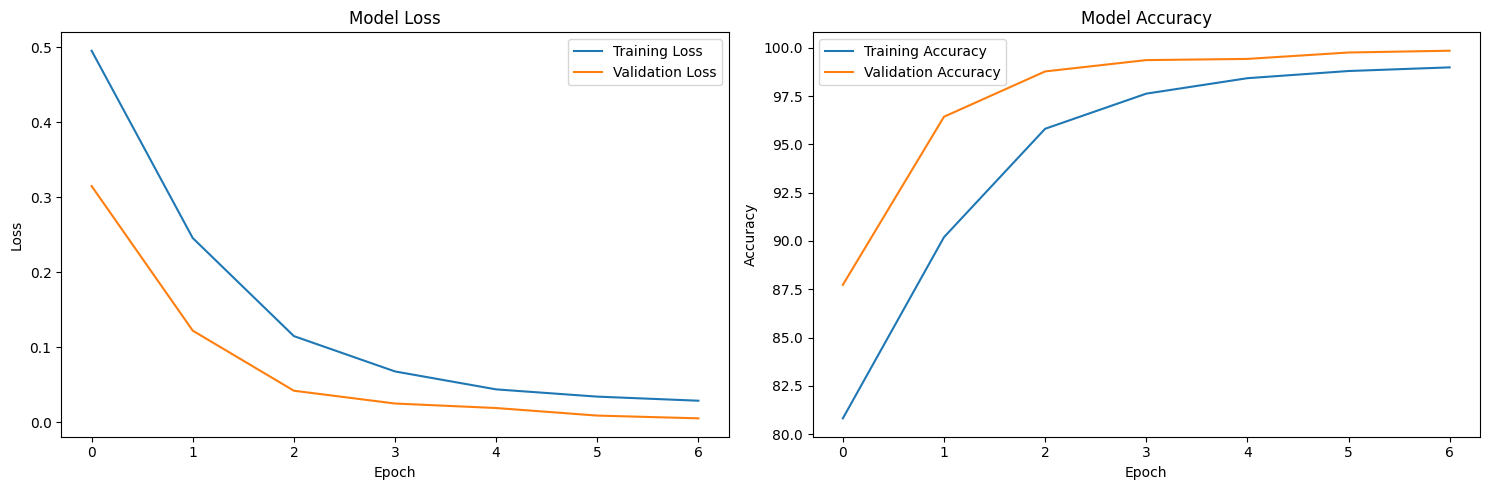

Validation: 100%|██████████| 203/203 [00:19<00:00, 10.33it/s, acc=99.9, loss=0.0045]  



Epoch 8/10:
  Train Loss: 0.0228 | Train Acc: 99.22%
  Val Loss: 0.0053 | Val Acc: 99.88%
  LR: 0.001000 | Time: 117.16s


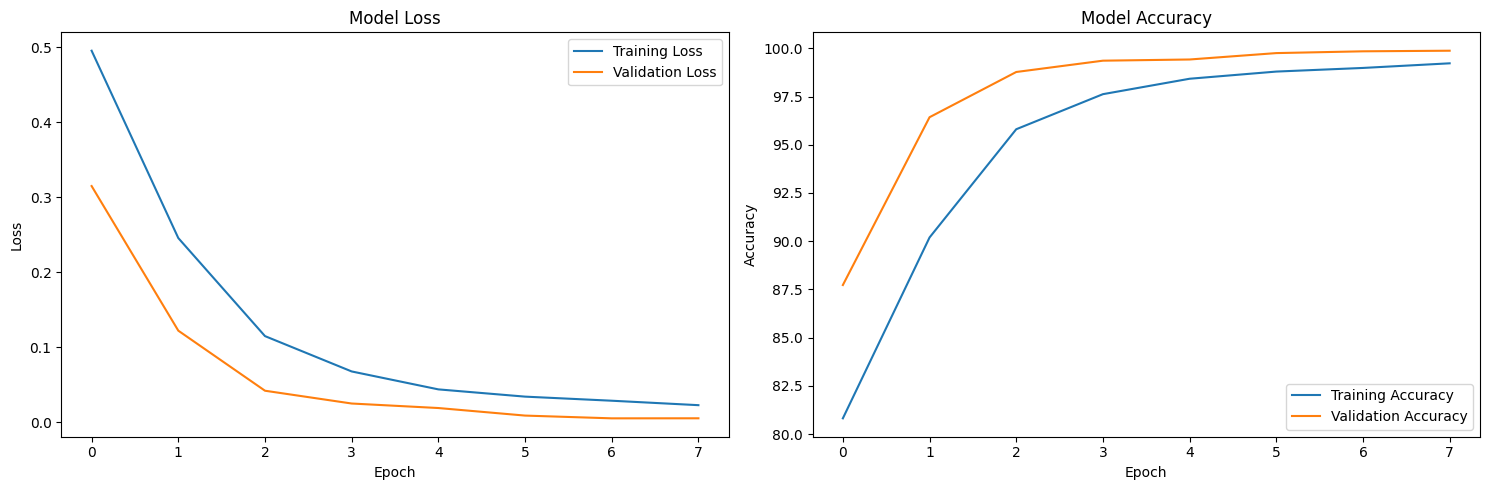

Validation: 100%|██████████| 203/203 [00:19<00:00, 10.34it/s, acc=99.9, loss=0.00135] 



Epoch 9/10:
  Train Loss: 0.0241 | Train Acc: 99.18%
  Val Loss: 0.0053 | Val Acc: 99.85%
  LR: 0.001000 | Time: 119.19s


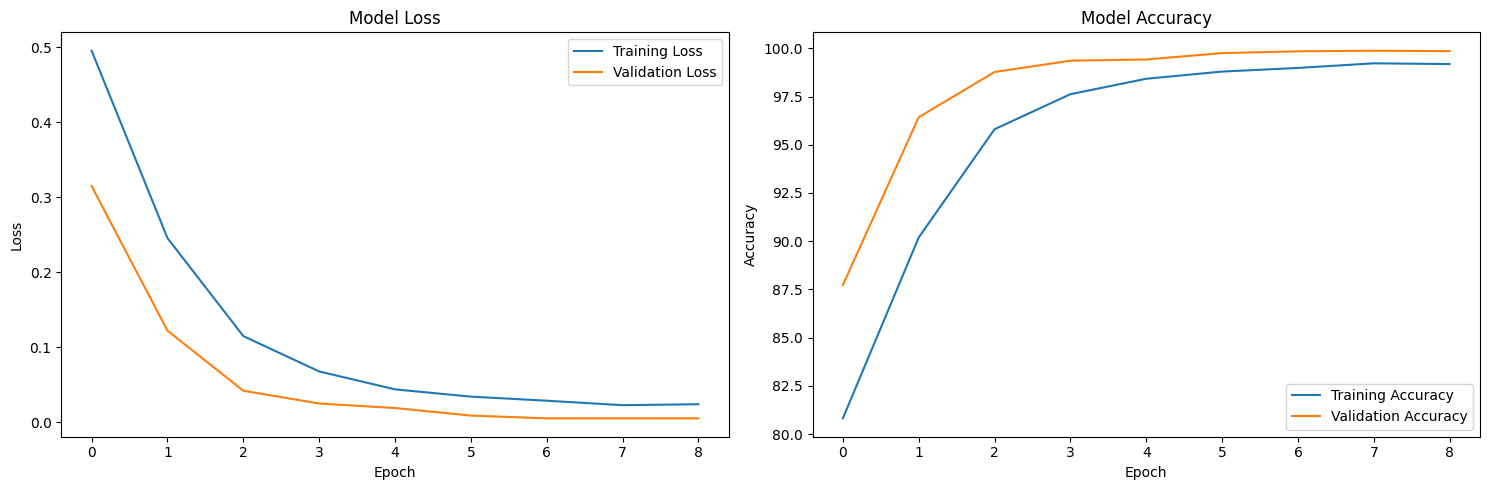

Validation: 100%|██████████| 203/203 [00:19<00:00, 10.31it/s, acc=99.9, loss=0.00121] 



Epoch 10/10:
  Train Loss: 0.0182 | Train Acc: 99.36%
  Val Loss: 0.0037 | Val Acc: 99.90%
  LR: 0.001000 | Time: 117.84s


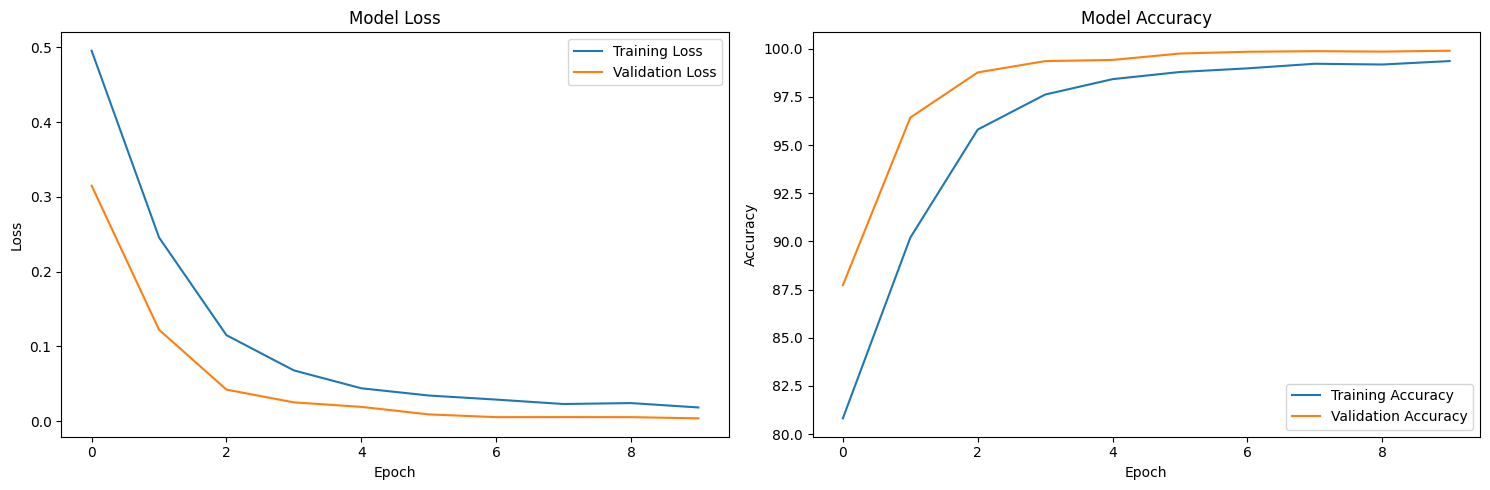


Evaluating on Test Set...


Validation: 100%|██████████| 203/203 [00:24<00:00,  8.19it/s, acc=99.9, loss=0.00399] 


Test Loss: 0.0031 | Test Acc: 99.91%


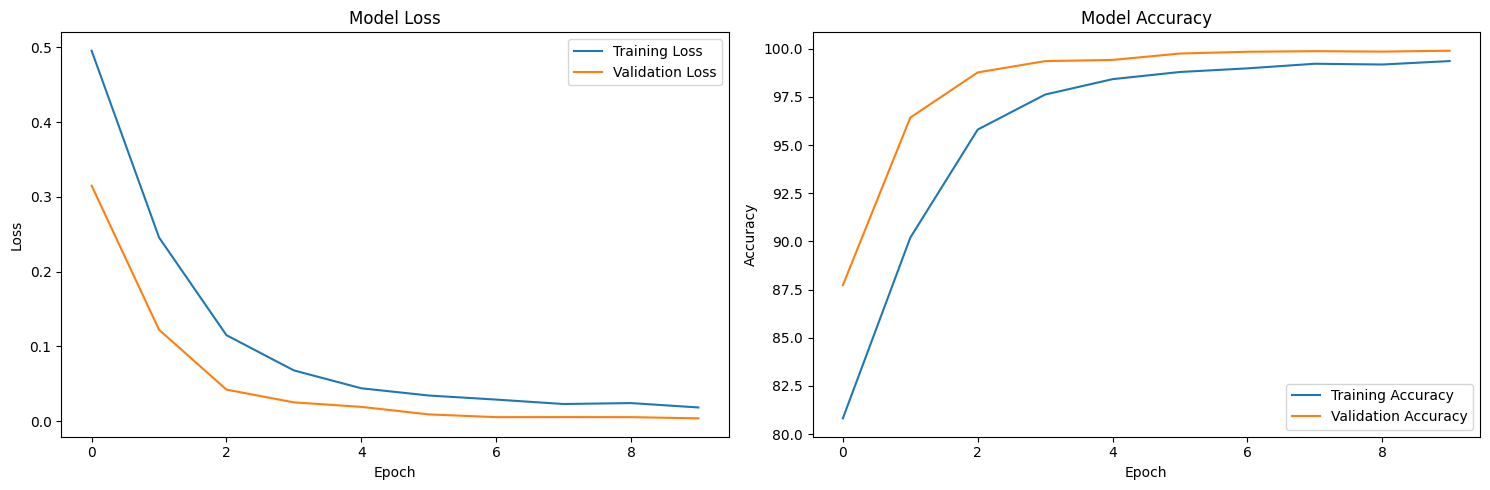


✅ Model saved to: /kaggle/working/alzheimers_model_corrected.pth


In [9]:
import os

def save_model(model, filename='alzheimers_model_corrected.pth'):
    """Save model state dict to Kaggle working directory"""
    save_path = os.path.join('/kaggle/working', filename)
    # If model is wrapped in DataParallel, save the underlying model
    if isinstance(model, torch.nn.DataParallel):
        torch.save(model.module.state_dict(), save_path)
    else:
        torch.save(model.state_dict(), save_path)
    print(f"\n✅ Model saved to: {save_path}")
    return save_path

def main():
    # Initialize config
    config = Config()
    
    # Get data loaders
    train_loader, val_loader, test_loader = get_data_loaders(config)
    
    # Initialize model
    model = get_model(num_classes=config.num_classes)
    
    # Print model summary
    print("Model Architecture:")
    print(model)
    
    # Count trainable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal Trainable Parameters: {total_params:,}")
    
    # Train model
    print("\nStarting Training...")
    model, history = train_model(model, train_loader, val_loader, config)
    
    # Evaluate on test set
    print("\nEvaluating on Test Set...")
    test_loss, test_accuracy = validate_model(model, test_loader, nn.CrossEntropyLoss().to(device))
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.2f}%')
    
    # Plot final training history
    plot_training_history(history)

    # Save the trained model
    save_model(model, filename='alzheimers_model_corrected.pth')
    
    return model, history

# Run everything
if __name__ == "__main__":
    model, history = main()


#model has been saved, now we have to load it and work with it


In [10]:
# At end of main()
torch.save(model.state_dict(), '/kaggle/working/alzheimers_model_corrected.pth')
print("✅ Model saved to /kaggle/working/alzheimers_model_corrected.pth")


✅ Model saved to /kaggle/working/alzheimers_model_corrected.pth


# import model and run it

✅ Model loaded successfully.

Class Index Mapping:
0: Mild Dementia
1: Moderate Dementia
2: Non Demented
3: Very mild Dementia


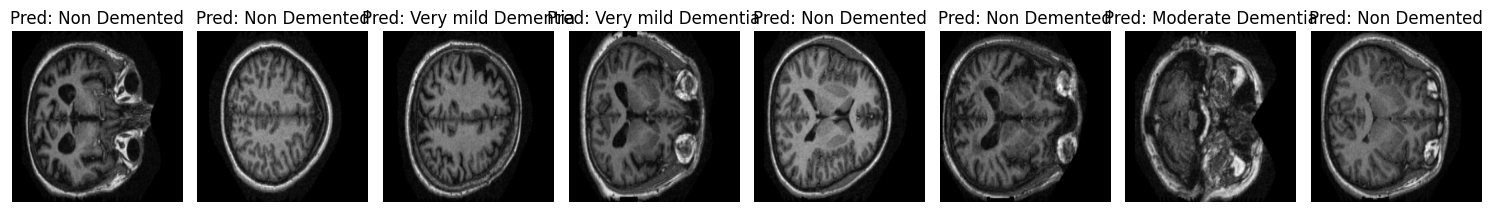

In [11]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 1. Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Define the same model class you used earlier
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.adaptive_pool = torch.nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(128 * 7 * 7, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

# 3. Load the model
def load_model(filename='alzheimers_model_corrected.pth', num_classes=4):
    model = SimpleCNN(num_classes=num_classes).to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(f'/kaggle/working/{filename}', map_location=device))
    model.eval()
    print("✅ Model loaded successfully.")
    return model

model = load_model()

# 4. Prepare test loader (match transform used during training)
test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_dataset = datasets.ImageFolder(
    root='/kaggle/input/imagesoasis/Data',
    transform=test_transform
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# 5. Print class-to-index mapping
class_to_idx = test_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("\nClass Index Mapping:")
for idx, label in idx_to_class.items():
    print(f"{idx}: {label}")

# 6. Show sample predictions
def show_predictions(model, data_loader, idx_to_class):
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(data_loader))
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        inputs = inputs.cpu()
        fig, axes = plt.subplots(1, len(inputs), figsize=(15, 3))
        for i in range(len(inputs)):
            image = inputs[i].squeeze()  # 1x256x256 → 256x256
            axes[i].imshow(image, cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f"Pred: {idx_to_class[preds[i].item()]}")
        plt.tight_layout()
        plt.show()

show_predictions(model, test_loader, idx_to_class)


## visualize class by class predictions 5 each

✅ Model loaded successfully.


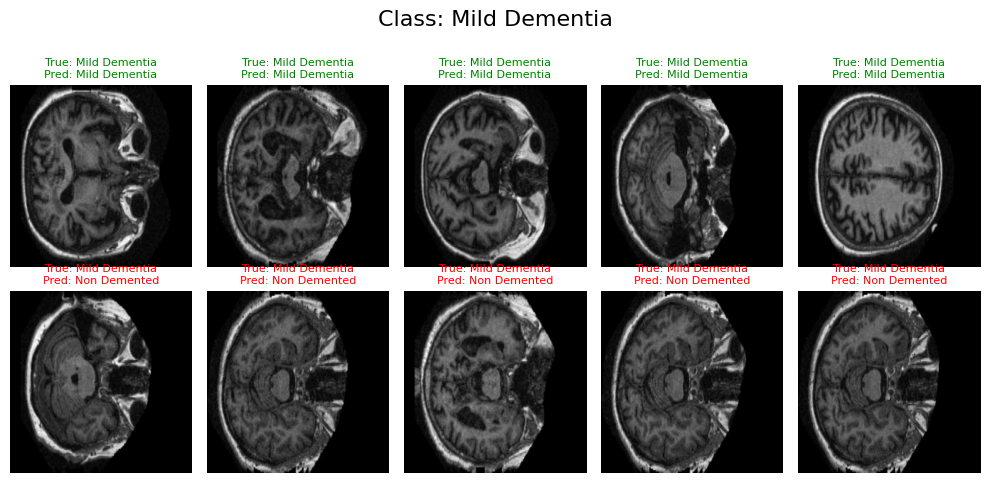

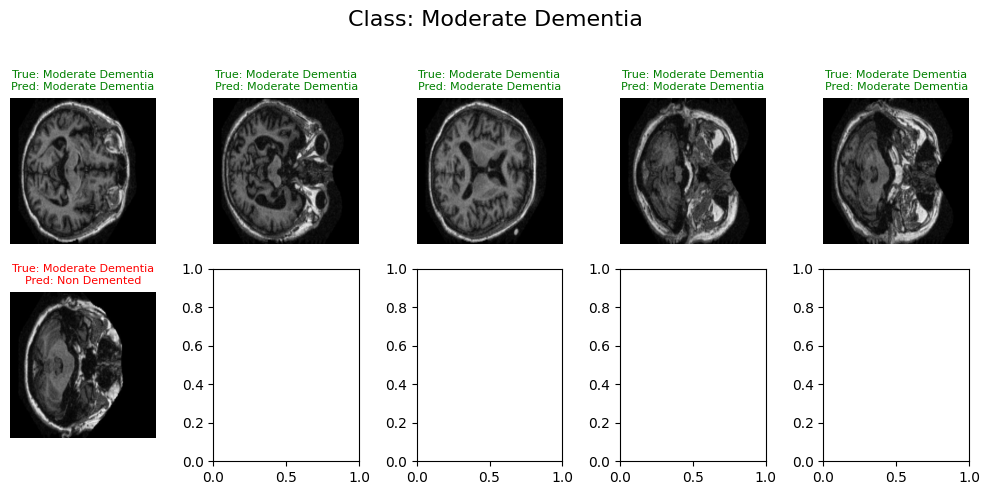

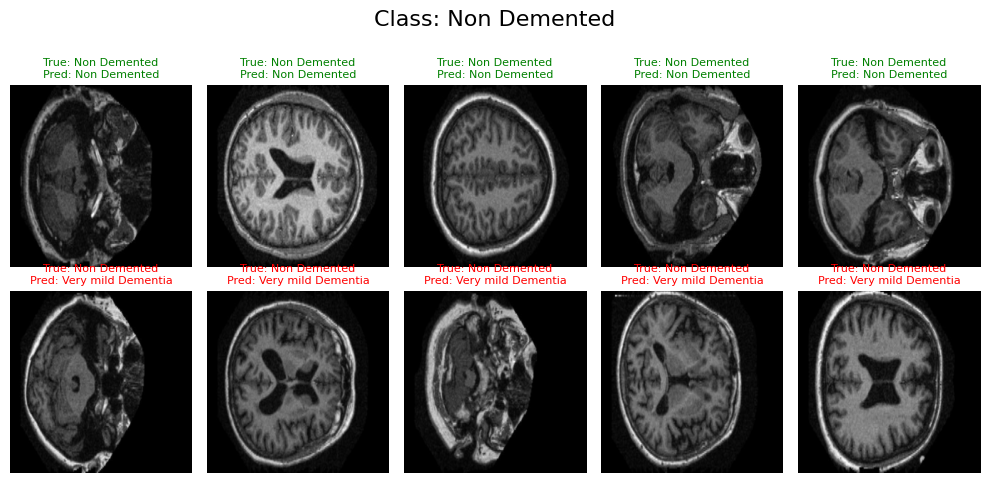

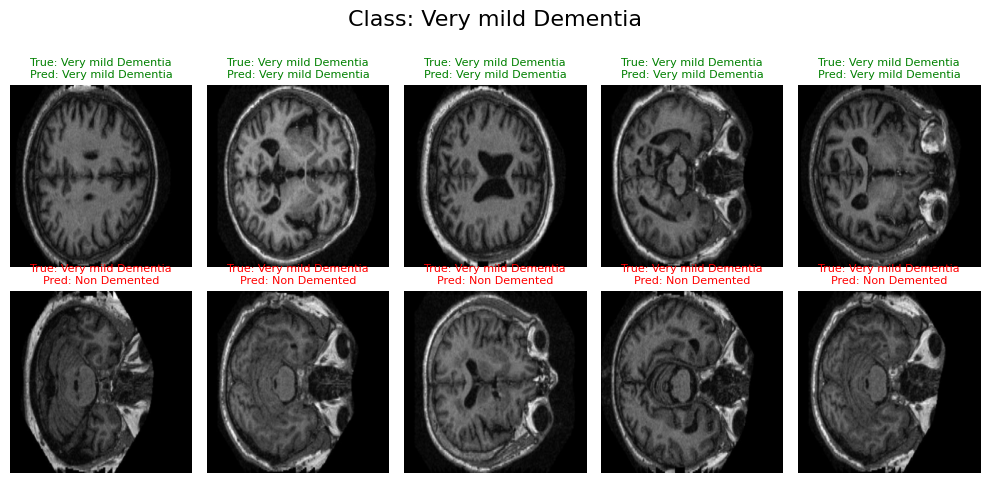

In [15]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.utils import make_grid

def visualize_predictions_by_class(model, dataloader, class_names, device='cuda', samples_per_class=5):
    model.eval()
    correct_samples = {cls: [] for cls in range(len(class_names))}
    wrong_samples = {cls: [] for cls in range(len(class_names))}

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(images)):
                true_label = labels[i].item()
                pred_label = preds[i].item()
                sample = (images[i].cpu(), true_label, pred_label)

                if true_label == pred_label:
                    if len(correct_samples[true_label]) < samples_per_class:
                        correct_samples[true_label].append(sample)
                else:
                    if len(wrong_samples[true_label]) < samples_per_class:
                        wrong_samples[true_label].append(sample)

            # Stop if we've collected enough for all classes
            if all(len(correct_samples[cls]) >= samples_per_class for cls in range(len(class_names))) and \
               all(len(wrong_samples[cls]) >= samples_per_class for cls in range(len(class_names))):
                break

    # Plot results
    for cls in range(len(class_names)):
        fig, axes = plt.subplots(2, samples_per_class, figsize=(samples_per_class * 2, 5))
        fig.suptitle(f"Class: {class_names[cls]}", fontsize=16)

        for i in range(samples_per_class):
            # Correct predictions
            if i < len(correct_samples[cls]):
                img, true, pred = correct_samples[cls][i]
                ax = axes[0][i]
                ax.imshow(img.squeeze(), cmap='gray')
                ax.set_title(f'True: {class_names[true]}\nPred: {class_names[pred]}', color='green', fontsize=8)
                ax.axis('off')

            # Wrong predictions
            if i < len(wrong_samples[cls]):
                img, true, pred = wrong_samples[cls][i]
                ax = axes[1][i]
                ax.imshow(img.squeeze(), cmap='gray')
                ax.set_title(f'True: {class_names[true]}\nPred: {class_names[pred]}', color='red', fontsize=8)
                ax.axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()


# Example usage:
loaded_model = load_model()  # First, get the model instance
visualize_predictions_by_class(loaded_model, test_loader, class_names, device=device, samples_per_class=5)




✅ Model loaded successfully.
Model predictions (green=correct, red=wrong):


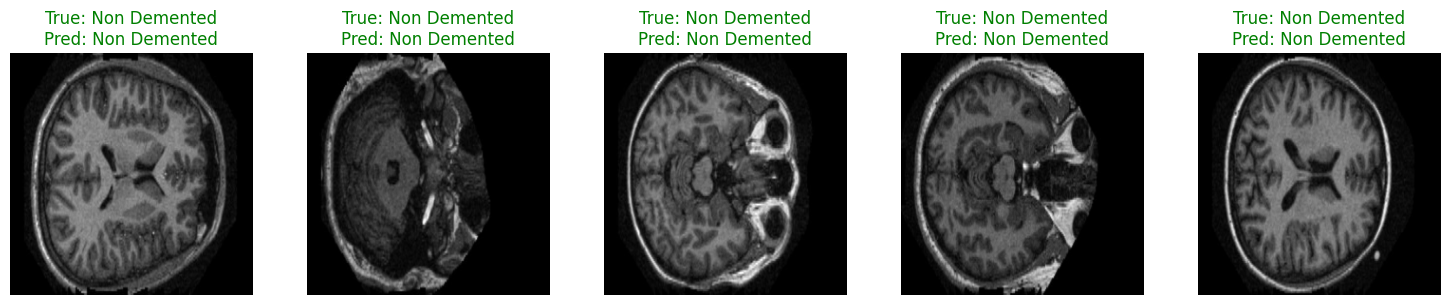

In [17]:
def show_predictions(model, loader, class_names, num_samples=5):
    model.eval()
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    # Move to device if needed
    if next(model.parameters()).is_cuda:
        images = images.cuda()
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Convert to CPU for visualization
    images = images.cpu()
    predicted = predicted.cpu()
    
    # Plot
    num_samples = min(num_samples, len(images))
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        img = images[i].numpy().transpose((1, 2, 0))
        if img.shape[2] == 1:  # Grayscale
            img = img.squeeze(-1)
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        
        true_label = class_names[labels[i]] if class_names else labels[i].item()
        pred_label = class_names[predicted[i]] if class_names else predicted[i].item()
        
        # Green if correct, red if wrong
        color = 'green' if labels[i] == predicted[i] else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

loaded_model = load_model()

# Show predictions
print("Model predictions (green=correct, red=wrong):")
show_predictions(loaded_model if 'loaded_model' in locals() else model, 
                test_loader, 
                class_names)

# model eval


✅ Model loaded successfully.


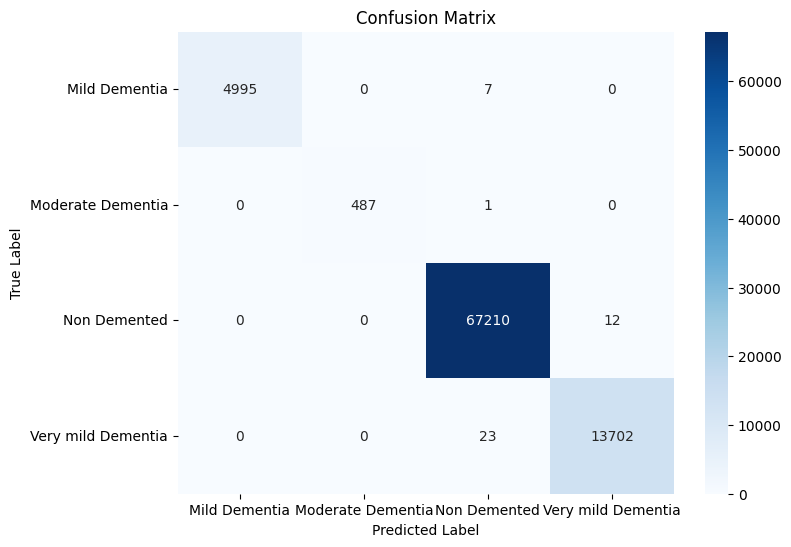


📊 Classification Report:

                    precision    recall  f1-score   support

     Mild Dementia     1.0000    0.9986    0.9993      5002
 Moderate Dementia     1.0000    0.9980    0.9990       488
      Non Demented     0.9995    0.9998    0.9997     67222
Very mild Dementia     0.9991    0.9983    0.9987     13725

          accuracy                         0.9995     86437
         macro avg     0.9997    0.9987    0.9992     86437
      weighted avg     0.9995    0.9995    0.9995     86437

✅ Accuracy: 99.95%
🔥 Macro AUC-ROC Score (OvO): 1.0000


In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, ConfusionMatrixDisplay
)
import seaborn as sns


def evaluate_model_metrics(model, dataloader, class_names, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification report
    print("\n📊 Classification Report:\n")
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)

    # Accuracy
    accuracy = np.mean(y_true == y_pred)
    print(f"✅ Accuracy: {accuracy * 100:.2f}%")

    # AUC-ROC Score (macro)
    try:
        y_true_oh = np.eye(len(class_names))[y_true]  # One-hot encoding
        auc_score = roc_auc_score(y_true_oh, y_prob, average="macro", multi_class="ovo")
        print(f"🔥 Macro AUC-ROC Score (OvO): {auc_score:.4f}")
    except Exception as e:
        print("⚠️ Could not calculate ROC AUC Score:", str(e))

loaded_model = load_model()
evaluate_model_metrics(loaded_model, test_loader, class_names, device=device)


# eval binary over entire test set

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

all_binary_preds = []
all_binary_targets = []
all_alz_probs = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        alz_prob = probs[:, 0] + probs[:, 1] + probs[:, 3]
        binary_preds = (alz_prob >= 0.5).long()
        binary_targets = (labels != 2).long()

        all_binary_preds.extend(binary_preds.cpu().numpy())
        all_binary_targets.extend(binary_targets.cpu().numpy())
        all_alz_probs.extend(alz_prob.cpu().numpy())

# Final report
print("📊 Full Test Set Binary Classification Report:")
print(classification_report(all_binary_targets, all_binary_preds, target_names=["No Alzheimer's", "Alzheimer's"]))

print("\n🧾 Confusion Matrix:")
print(confusion_matrix(all_binary_targets, all_binary_preds))

print("\n🔵 ROC AUC Score:", round(roc_auc_score(all_binary_targets, all_alz_probs), 4))


📊 Full Test Set Binary Classification Report:
                precision    recall  f1-score   support

No Alzheimer's       1.00      1.00      1.00     67222
   Alzheimer's       1.00      1.00      1.00     19215

      accuracy                           1.00     86437
     macro avg       1.00      1.00      1.00     86437
  weighted avg       1.00      1.00      1.00     86437


🧾 Confusion Matrix:
[[67210    12]
 [   31 19184]]

🔵 ROC AUC Score: 1.0
